In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')

In [48]:
device = torch.device('cpu')

In [5]:
device

device(type='cuda')

In [15]:
gen = torch.Generator(device=device)
x = torch.randn((1024, 1024), device=device, generator=gen)
x.shape, x.stride(), x.data_ptr(), x.dtype

(torch.Size([1024, 1024]), (1024, 1), 23449854541824, torch.float32)

In [16]:
hex(x.data_ptr())

'0x1553d8400000'

In [17]:
x[0][0].data_ptr()

23449854541824

In [18]:
x[0][1].data_ptr()

23449854541828

In [19]:
h, w = x.shape

In [20]:
x[0][w-1].data_ptr(), x[1][0].data_ptr()

(23449854545916, 23449854545920)

In [25]:
x1 = torch.randn((1024, 512, 256), device=device, generator=gen)
x1.shape, x1.stride(), x1.data_ptr()

(torch.Size([1024, 512, 256]), (131072, 256, 1), 23447837081600)

In [24]:
print(512*512)

262144


In [27]:
y = x1.transpose(-2, -1)
y.shape, y.stride(), y.data_ptr()

(torch.Size([1024, 256, 512]), (131072, 1, 256), 23447837081600)

In [28]:
x = torch.randn((1024, 1024), device=device)
y = x.transpose(0, 1)
x.shape, y.shape, x.stride(), y.stride(), x.data_ptr(), y.data_ptr()

(torch.Size([1024, 1024]),
 torch.Size([1024, 1024]),
 (1024, 1),
 (1, 1024),
 23449850347520,
 23449850347520)

In [29]:
y.is_contiguous()

False

In [30]:
x.is_contiguous()

True

In [ ]:
def is_contiguous_fast(z):
    stride_values = z.stride()
    i = len(stride_values)-1
    shape_values = z.shape
    current = 1
    while i>=0:
        if stride_values[i] != current:
            return False
        current *= shape_values[i]
        i-=1
    return True
          

In [45]:
is_contiguous_fast(y)

False

In [57]:
x = torch.randn((1024, 512, 256))
x.shape, x.stride(), x.data_ptr()

(torch.Size([1024, 512, 256]), (131072, 256, 1), 23447300206656)

In [58]:
y = x.transpose(-2, -1)
y.shape, y.stride(), y.data_ptr()

(torch.Size([1024, 256, 512]), (131072, 1, 256), 23447300206656)

In [59]:
is_contiguous_fast(x)

True

In [51]:
print(256*512)

131072


In [60]:
is_contiguous_fast(y)

(131072, 1, 256) torch.Size([1024, 256, 512]) 2 1


False

In [61]:
is_contiguous_fast(y.view(-1))

RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [63]:
y = y.view(-1)

RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [64]:
y.view(-1)

RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [65]:
y.shape

torch.Size([1024, 256, 512])

In [68]:
x.transpose(-1, -1).view(-1)

tensor([ 1.4496,  0.0308, -1.4092,  ...,  1.0776,  0.9064,  0.2648])

In [67]:
y.view(-1)

RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [19]:
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.dim = dim
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones((1, self.dim)))
    
    def forward(self, x):
        var_values = torch.mean(x**2, dim=-1, keepdim=True)
        norm_values = x / torch.sqrt(var_values + self.eps)
        out = norm_values * self.alpha
        return out

In [20]:
x = torch.randn((2, 10), requires_grad=True)

In [21]:
m = RMSNorm(10)

In [22]:
out = m(x)

In [23]:
m1 = nn.RMSNorm(10)

In [24]:
out1 = m1(x)

In [25]:
torch.allclose(out, out1)

True

In [26]:
out, out1

(tensor([[ 0.2277, -0.5497,  0.9793, -1.0608, -1.0246,  1.0161,  1.1578,  0.9384,
           0.0446, -1.8045],
         [-0.8876, -0.0037, -0.6157, -0.9243,  1.0888, -0.8053,  1.9238, -0.1788,
          -1.0020, -1.1863]], grad_fn=<MulBackward0>),
 tensor([[ 0.2277, -0.5497,  0.9793, -1.0608, -1.0246,  1.0161,  1.1578,  0.9384,
           0.0446, -1.8045],
         [-0.8876, -0.0037, -0.6157, -0.9243,  1.0888, -0.8053,  1.9238, -0.1788,
          -1.0020, -1.1863]], grad_fn=<MulBackward0>))

In [4]:
logits = torch.tensor([10.0, 50.0, 100.0], dtype=torch.float32)

In [5]:
def softmax(logits: torch.Tensor):
    exp_values = torch.exp(logits)
    sum_exp_values = torch.sum(exp_values, dim=-1)
    probs = exp_values/sum_exp_values
    return probs

In [6]:
probs = softmax(logits)

In [7]:
probs

tensor([0., 0., nan])

In [8]:
logits = torch.tensor([100.0, 5000.0, 10000.0], dtype=torch.float32)
softmax(logits)

tensor([nan, nan, nan])

In [9]:
def stabel_softmax(logits: torch.Tensor, dim=-1):
    max_values = torch.max(logits, dim=dim, keepdim=True).values
    shifted_logits = logits - max_values
    exp_values = torch.exp(shifted_logits)
    sum_exp_values = torch.sum(exp_values, dim=dim, keepdim=True)
    out = exp_values/sum_exp_values
    return out

In [10]:
logits = torch.tensor([10.0, 100.0, 1000.0], dtype=torch.float32)

In [12]:
out_original = F.softmax(logits, dim=-1)
out_custome = stabel_softmax(logits, dim=-1)

In [13]:
out_original, out_custome

(tensor([0., 0., 1.]), tensor([0., 0., 1.]))

In [56]:
def stabel_log_softmax(logits: torch.Tensor, targets: torch.Tensor, dim=-1):
    target_logits = torch.gather(logits, dim=-1, index=targets.unsqueeze(-1)).squeeze(-1)
    out = target_logits - torch.logsumexp(logits, dim=dim)
    return out

In [26]:
logits = torch.tensor([10.0, 100.0, 1000.0], dtype=torch.float32)

In [27]:
out_original = F.log_softmax(logits, dim=-1)
out_custome = stabel_log_softmax(logits, dim=-1)

In [28]:
out_original, out_custome

(tensor([-990., -900.,    0.]), tensor([-990., -900.,    0.]))

In [63]:
def cross_entropy_custome(logits: torch.Tensor, target_idx: torch.Tensor):
    total_sum = -(torch.sum(logits)/target_idx.shape[0])
    return total_sum

In [64]:
gen = torch.manual_seed(42)
logits = torch.randn((10, 2, 50), generator=gen)
target_ids = torch.randint(0, 50, (10, 2), generator=gen)

In [65]:
probs = stabel_log_softmax(logits, target_ids, dim=-1)

In [66]:
probs.shape

torch.Size([10, 2])

In [67]:
probs

tensor([[-4.0583, -4.5662],
        [-4.3963, -6.2195],
        [-5.3560, -4.9486],
        [-5.5232, -4.2834],
        [-4.0594, -3.3880],
        [-3.5311, -3.7295],
        [-5.3921, -5.3590],
        [-3.4083, -3.0989],
        [-2.9292, -4.8420],
        [-4.1020, -5.8753]])

In [68]:
# out_default = F.nll_loss(probs.view(-1, 50), target_ids.view(-1))
out_custome = cross_entropy_custome(probs, target_ids.view(-1))

In [69]:
out_custome

tensor(4.4533)

In [4]:
import model.ops as ops
print(dir(ops))

['F', 'RMSNorm', 'SiLU', 'SiLuCustome', 'SwiGLUCustome', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'nn', 'sigmoid', 'stabel_log_softmax', 'stable_softmax', 'torch']


In [1]:
import model.ops as ops
print(dir(ops))

['F', 'LayerNormFunction', 'MyLayerNorm', 'RMSNorm', 'SiLU', 'SiLuCustome', 'SwiGLUCustome', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'nn', 'sigmoid', 'stabel_log_softmax', 'stable_softmax', 'torch']


In [3]:
from model.ops import CrossEntropyLossCustom, SiLU, RMSNorm, stable_log_softmax, stable_softmax
from config import device

In [4]:
device

device(type='cuda')

In [103]:
gen = torch.Generator(device)
gen.manual_seed(42)
logits = nn.Parameter(torch.randn((2, 50), generator=gen, device=device, requires_grad=True))
logits.retain_grad()
target_ids = torch.randint(0, 50, (2,), generator=gen, device=device)

In [104]:
rms_norm = RMSNorm(dim=50).to(device)
criterion = CrossEntropyLossCustom()

In [105]:
interm_logits = SiLU(logits)
interm_logits = rms_norm(interm_logits)
probs = stable_softmax(interm_logits, dim=-1)
values = criterion(probs.view(-1, 50), target_ids.view(-1))

In [106]:
values

tensor(-0.0152, device='cuda:0', grad_fn=<NegBackward0>)

In [107]:
values.backward()

In [108]:
logits[0, :].data

tensor([ 0.1940,  2.1614, -0.1721,  0.8491, -1.9244,  0.6530, -0.6494, -0.8175,
         0.5280, -1.2753, -1.6621, -0.3033, -0.0926,  0.1992, -1.1204,  1.8577,
        -0.7145,  0.6881,  0.7968, -0.0334,  1.4917, -0.5165, -0.2541,  1.4746,
        -0.3260, -1.1600,  2.3551, -0.6924,  0.1837, -1.1835, -1.8029, -1.5808,
         0.8387,  1.4192,  0.6469,  0.4253, -1.5892,  0.6223,  1.6898, -0.6648,
         0.9425,  0.0783,  0.0847, -0.1408,  0.3316, -0.5890, -1.0723,  0.0954,
        -0.3347, -0.5258], device='cuda:0')

In [109]:
logits.grad

tensor([[ 4.7952e-05,  1.4466e-03,  5.1332e-05, -1.2486e-02, -1.4670e-05,
          2.4803e-05,  3.2096e-05,  2.2684e-05,  3.1175e-05,  1.2191e-07,
         -1.1105e-05,  4.8061e-05,  5.2240e-05,  4.7766e-05,  6.8079e-06,
          6.6121e-04,  2.8478e-05,  2.3378e-05,  2.0778e-05,  5.2338e-05,
          2.0728e-04,  3.9102e-05,  4.9527e-05,  1.9478e-04,  4.7296e-05,
          4.9896e-06,  2.2557e-03,  2.9713e-05,  4.8308e-05,  3.9419e-06,
         -1.3368e-05, -9.3820e-06,  2.0764e-05,  1.5833e-04,  2.5070e-05,
          3.6979e-05, -9.5767e-06,  2.6210e-05,  4.0284e-04,  3.1249e-05,
          2.4062e-05,  5.1119e-05,  5.0995e-05,  5.1792e-05,  4.1994e-05,
          3.5368e-05,  9.1184e-06,  5.0771e-05,  4.6991e-05,  3.8638e-05],
        [ 3.3032e-05, -7.0441e-05,  4.2659e-06,  6.0754e-05, -3.3355e-04,
         -4.5458e-06,  6.5095e-05,  5.2603e-05, -9.1556e-05,  5.9495e-05,
         -3.5978e-04,  3.8640e-05, -2.0272e-05,  6.4001e-05, -3.5584e-04,
          1.3331e-05, -1.3791e-04, -4

In [110]:
with torch.no_grad():
    logits -= 1.0 * logits.grad
    logits.grad.zero_()

In [111]:
logits.data, logits.grad

(tensor([[ 0.1940,  2.1599, -0.1721,  0.8615, -1.9244,  0.6530, -0.6495, -0.8175,
           0.5279, -1.2753, -1.6621, -0.3034, -0.0926,  0.1992, -1.1204,  1.8570,
          -0.7145,  0.6881,  0.7968, -0.0335,  1.4915, -0.5165, -0.2541,  1.4744,
          -0.3261, -1.1600,  2.3529, -0.6925,  0.1837, -1.1835, -1.8029, -1.5807,
           0.8386,  1.4190,  0.6469,  0.4252, -1.5892,  0.6223,  1.6894, -0.6648,
           0.9425,  0.0783,  0.0846, -0.1409,  0.3315, -0.5890, -1.0723,  0.0953,
          -0.3347, -0.5258],
         [-0.8777,  0.3939,  0.1640, -0.1977,  1.0107, -1.3482, -0.3498, -0.6443,
           0.4469, -0.5372,  1.2427, -0.8146,  0.2502, -0.4273,  1.1047, -1.1028,
           0.5545, -1.2847, -0.3816,  0.5234,  0.1002,  0.2586,  0.3617,  2.2747,
           0.0233,  1.5829, -1.1592,  0.9487, -0.4574,  0.7608, -0.5787, -0.7051,
          -0.7234, -0.5071, -0.4399, -0.4182,  0.1741,  0.4428,  0.5070, -1.2168,
          -0.2719,  0.2766, -1.4398, -0.6464,  0.0748,  0.1939,  0.59

In [49]:
gen = torch.Generator(device)
gen.manual_seed(42)
x = torch.randn((2, 2), device=device, generator=gen)

In [50]:
val = torch.tensor(3, device=device, dtype=x.dtype)

In [51]:
val, val.item()

(tensor(3.), 3.0)

In [52]:
val.add_(torch.linalg.norm(x))

tensor(3.4878)

In [53]:
(x ** 2).sum() + val

tensor(3.7258)

In [61]:
x

tensor([[0.3367, 0.1288],
        [0.2345, 0.2303]])

In [62]:
torch.abs(x).sum()

tensor(0.9303)

In [57]:
(x ** 2).sum()

tensor(0.2380)

In [58]:
torch.sqrt((x ** 2).sum())

tensor(0.4878)

In [70]:
torch.linalg.norm(x, ord='fro')

tensor(0.4878)

In [67]:
torch.linalg.norm(x.view(-1), ord=1)

tensor(0.9303)

In [75]:
torch.linalg.norm(x.contiguous().view(-1), ord=2)

tensor(0.4878)

In [45]:
x.norm(2)

tensor(1.1963, device='mps:0')

In [74]:
torch.dot(x.view(-1), x.view(-1))

tensor(0.2380)

In [44]:
val.add_(torch.dot(x.contiguous().view(-1), x.contiguous().view(-1)))

tensor(5.6274, device='mps:0')

In [211]:
gen = torch.Generator(device)
gen.manual_seed(42)
v = torch.randn((1, 4), generator=gen, device=device)
x = torch.randn((4, 4), generator=gen, device=device)

In [182]:
v.dim()

2

In [183]:
v_hist = []
x_t = x.transpose(-2, -1)
result = torch.zeros_like(v)
for _ in range(40):
    torch.matmul(v, x, out=result)
    torch.matmul(result, x_t, out=v)
    norm_factor = torch.linalg.vector_norm(v.view(-1), ord=2)
    v.div_(norm_factor)
    v_hist.append(v.detach().clone())

In [184]:
v_hist = torch.cat(v_hist, dim=0).cpu()

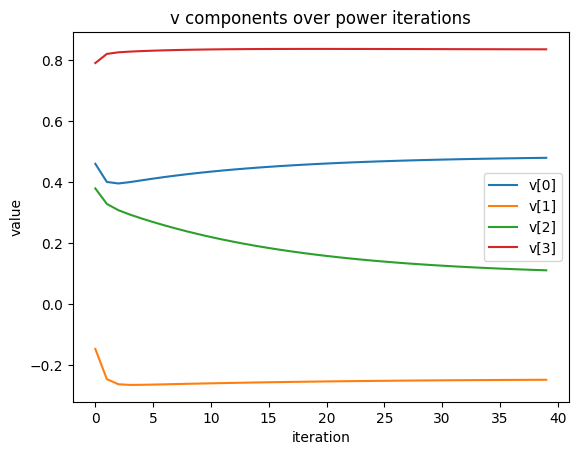

In [185]:
import matplotlib.pyplot as plt

t = range(v_hist.shape[0])
for j in range(v_hist.shape[1]):
    plt.plot(t, v_hist[:, j], label=f"v[{j}]")
plt.xlabel("iteration")
plt.ylabel("value")
plt.legend()
plt.title("v components over power iterations")
plt.show()

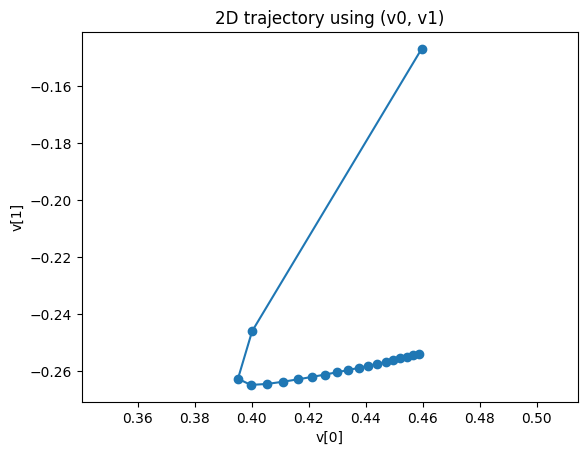

In [180]:
plt.plot(v_hist[:, 0], v_hist[:, 1], marker="o")
plt.xlabel("v[0]")
plt.ylabel("v[1]")
plt.title("2D trajectory using (v0, v1)")
plt.axis("equal")
plt.show()

In [172]:
v = torch.matmul(v, x)

In [173]:
torch.linalg.norm(v.view(-1), ord=1)

tensor(5.9314)

In [174]:
torch.sqrt((v ** 2).sum())

tensor(3.2566)

In [121]:
torch.matmul(x, x.transpose(-2, -1))

tensor([[ 5.6153,  1.0723, -4.2436,  1.6154],
        [ 1.0723,  3.3487,  0.7321, -1.3238],
        [-4.2436,  0.7321,  4.2722, -2.0217],
        [ 1.6154, -1.3238, -2.0217,  2.4708]])

In [194]:
x

tensor([[ 1.7878, -0.4780, -0.2429, -0.9342],
        [-0.2483, -1.2082, -0.4777,  0.5201],
        [-1.5673, -0.2394,  2.3228, -0.9634],
        [ 2.0024,  0.4664,  1.5730, -0.9228]])

In [193]:
x.addcmul(x, x)

tensor([[ 4.9840, -0.2495, -0.1839, -0.0615],
        [-0.1866,  0.2516, -0.2495,  0.7907],
        [ 0.8892, -0.1821,  7.7182, -0.0353],
        [ 6.0121,  0.6840,  4.0474, -0.0712]])

In [200]:
(x ** 2)

tensor([[3.1962, 0.2285, 0.0590, 0.8727],
        [0.0616, 1.4598, 0.2282, 0.2705],
        [2.4565, 0.0573, 5.3954, 0.9281],
        [4.0097, 0.2176, 2.4744, 0.8516]])

In [ ]:
torch.mul(x, x, out=x)

tensor([[3.1962, 0.2285, 0.0590, 0.8727],
        [0.0616, 1.4598, 0.2282, 0.2705],
        [2.4565, 0.0573, 5.3954, 0.9281],
        [4.0097, 0.2176, 2.4744, 0.8516]])

In [198]:
x

tensor([[3.1962, 0.2285, 0.0590, 0.8727],
        [0.0616, 1.4598, 0.2282, 0.2705],
        [2.4565, 0.0573, 5.3954, 0.9281],
        [4.0097, 0.2176, 2.4744, 0.8516]])

In [ ]:
torch.mul(x, x).sum()

tensor(22.7671)

In [205]:
val = torch.tensor(4, dtype=torch.float32)

In [206]:
val.sqrt_()

tensor(2.)

In [207]:
val

tensor(2.)

In [209]:
val.device

device(type='cpu')

In [216]:
x

tensor([[ 1.7878, -0.4780, -0.2429, -0.9342],
        [-0.2483, -1.2082, -0.4777,  0.5201],
        [-1.5673, -0.2394,  2.3228, -0.9634],
        [ 2.0024,  0.4664,  1.5730, -0.9228]])

In [213]:
(x**2).sum()

tensor(22.7671)

In [218]:
torch.sqrt(x.view(-1).dot(x.view(-1)))

tensor(4.7715)

In [219]:
torch.linalg.vector_norm(x, ord=2, dtype=torch.float32).square()

tensor(22.7671)